### Imports

In [20]:
import os
import sys
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

#--- Get absolute path to the utils folder---
from pathlib import Path
utils_path = Path.cwd() / "utils"
sys.path.append(str(utils_path))

backtesting_path = Path.cwd() / "backtesting"
sys.path.append(str(backtesting_path))

from notebooks.utils.config_utils import load_config
from notebooks.utils.data_utils import load_dataset, preprocess_data
from notebooks.utils.model_utils import initialise_model, grid_search, get_feature_importance, optimise_threshold
from notebooks.utils.plotting_utils import plot_correlation, plot_scatter, plot_roc_and_prc, plot_classification_report, plot_point_biserial_correlation
from notebooks.utils.pdf_utils import create_markdown_report, update_markdown_with_model_details, convert_markdown_to_html, save_pdf_from_html

from notebooks.backtesting.backtester import Backtester

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

import numpy as np

### Load config.yaml

In [21]:
# Test load
config = load_config()

Config loaded successfully!


### Load the dataset

In [22]:
df = load_dataset(config)
df_selected, selected_features, constructed_features, target_variable = preprocess_data(df, config)

df_selected

📁 Dataset Loaded: 9074 rows, 112 columns
✅ Dataset Preprocessed: 9071 rows, 28 columns


,id_odsp,date,season,league,country,home_team,away_team,score_pre_80,score_ft,game_state_80,...,odds_ratio,shot_to_corner_ratio_pre_80,home_urgency_to_attack,away_urgency_to_attack,home_momentum_to_attack,away_momentum_to_attack,attack_intensity,defensive_pressure,trailing_team_probability,corner_diff
0,UFot0hit/,2011-08-05,2012,D1,germany,Borussia Dortmund,Hamburg SV,3-1,3-1,h,...,0.210,1.692,0.000,0.067,0.000,0.067,0,-2,13.477,1
1,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,1-2,2-2,a,...,0.694,2.429,0.424,0.000,-0.424,-0.000,0,-3,42.373,2
2,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,0-1,0-1,a,...,0.165,2.222,0.645,0.000,1.935,-0.000,3,0,64.516,4
3,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,1-0,1-0,h,...,0.725,1.900,0.000,0.290,0.000,0.000,0,-2,28.986,4
4,M7PhlM2C/,2011-08-06,2012,F1,france,Brest,Evian Thonon Gaillard,2-2,2-2,d,...,0.595,2.000,0.627,0.373,2.508,0.000,0,-1,25.974,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,vJy048Er/,2017-01-22,2017,I1,italy,Empoli,Udinese,0-0,1-0,d,...,0.980,1.250,0.505,0.495,-0.505,0.000,0,0,33.784,1
9070,xAkY8l6R/,2017-01-22,2017,I1,italy,Genoa,Crotone,2-2,2-2,d,...,0.246,2.100,0.802,0.198,-0.802,-0.396,0,0,12.500,2
9071,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1-0,2-0,h,...,0.060,1.000,0.000,0.050,0.000,0.050,1,-2,5.000,1
9072,xY7uZwOI/,2017-01-22,2017,F1,france,AS Monaco,Lorient,4-0,4-0,h,...,0.115,2.375,0.000,0.000,0.000,0.000,0,0,8.696,0


# Classification Pipeline

- **Feature Selection**: 
    - Trains only on selected and constructed features
- **Data Splitting**:
    - Exclude the last 500 rows for testing
    - Split remaining data into 80% train and 20% validation sets
- **Model Training Loop**:
    1) Initialise each model from config yaml
    2) Apply MinMax scaling... *only for models that require scaling*
    3) Perform grid search for hyperparameter tuning (if specified) and Train Model
    4) Predict on validation set and display feature importance
    5) Optimise precision-recall threshold
    6) Evaluate model on validation set using optimised threshold
    7) Plot ROC and Precision-Recall graphs
    8) Predict on the test set (last 500 rows) and evaluate
    9) Save the trained model
    10) Save predictions (for backtesting).
    11) Plot Scatter Graph.

In [37]:
def run_regression_pipeline(config, df, selected_features, constructed_features, target_variable, show_output=False, generate_pdf=False): 
    models_to_train = config['model']['regression']['models']
    
    # # Step 1: Create the Markdown for the report
    # if generate_pdf:
    #     markdown_content = create_markdown_report(config, feature_correlation_image_path, target_variable, selected_features, constructed_features, models_to_train)   
    
    # Only train on selected and constructed features
    X = df[selected_features + constructed_features]
    y = df[target_variable]

    # Split data to exclude the last 500 rows for testing
    train_data = df.iloc[:-500]
    test_data = df.iloc[-500:]

    # Split data -> train & validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_data[selected_features + constructed_features],
        train_data[target_variable],
        test_size=0.2,
        random_state=42
    )

    # Create X and y for testset
    X_test= test_data[selected_features+constructed_features]
    y_test = test_data[target_variable]

    # MinMax Scaling for models that require scaling...
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # --- MODEL TRAINING LOOP ---
    for model_name in models_to_train:
        print(f"\n-> Training {model_name}...")

        # Get the hyperparameters for the model
        hyperparameters = config["model"]["regression"]["hyperparameters"].get(model_name, {})
        do_grid_search = config["model"]["regression"].get("grid_search", False)
        
        # Initialize the model
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        model.fit(X_train, y_train)

        # --- STEP 4: Predict on the validation set ---
        y_pred_val = model.predict(X_val)
        # y_pred_val = np.round(y_pred_val, 3)

        accuracy = accuracy_score(y_val, y_pred_val)
        print(f"Accuracy: {accuracy}")

        # #Calc probabilities and implied odds for each prediction...
        # prob_at_least_1=[probability_at_least_one_corner(pred) for pred in y_pred_val]
        # implied_odds_list =[implied_odds(pred) for pred in y_pred_val]

        # #Measures to eval model performnce:
        # mae= mean_absolute_error(y_val,y_pred_val)
        # mse =mean_squared_error(y_val, y_pred_val)
        # rmse= mse**0.5

        # print("\n### Model Performance ###")
        # print(f"Mean Absolute Error (MAE): {mae:.4f}")
        # print(f"Mean squared Error (MSE): {mse:.4f}")
        # print(f"Root Mean Squared error (RMSE): {rmse:.4f}")

        # #Create a df with features, actual corner difference, and predictions
        # # pred_df =X_val.copy()
        # # pred_df['corner_diff'] = y_val.values 
        # # pred_df['y_pred'] = y_pred_val
        # # pred_df['prob_at_least_1_corner'] =prob_at_least_1
        # # pred_df['implied_odds'] = implied_odds_list
        # # print(pred_df.head())

        #--------------- TEST SET -----------------

        y_pred_test = model.predict(X_test)

        # # --- STEP 8: Save Predictions ---
        prediction_file = f"../data/predictions/{model_name.replace(' ', '_').lower()}_multi_class_predictions.csv"
        results_df = pd.DataFrame({
            'kaggle_id': test_data['id_odsp'],
            'model_predicted_binary': y_pred_test>=2,
            'actual_result': (y_test>0)
        })
        results_df.to_csv(prediction_file, index=False)
        if show_output:
            print(f"Predictions saved for {model_name}.")

        # # --- STEP 9: Plot and Save the Graph ---
        scatter_image_path = plot_scatter(y_pred_test, (y_test>0), model_name, show_output)

        print(f"\n-> Running Backtest...")
        odds_file = config["paths"]["total_corner_odds"]  # Ensure this exists in config.yaml
        backtester = Backtester(config, odds_file=odds_file, model_file=prediction_file, model_type="classification")
        backtesting_image_path, backtesting_results_list = backtester.run(show_output)

    print("✅ Finished Running Regression Pipeline")


-> Training random_forest...
Accuracy: 0.31486880466472306
Predictions saved for random_forest.


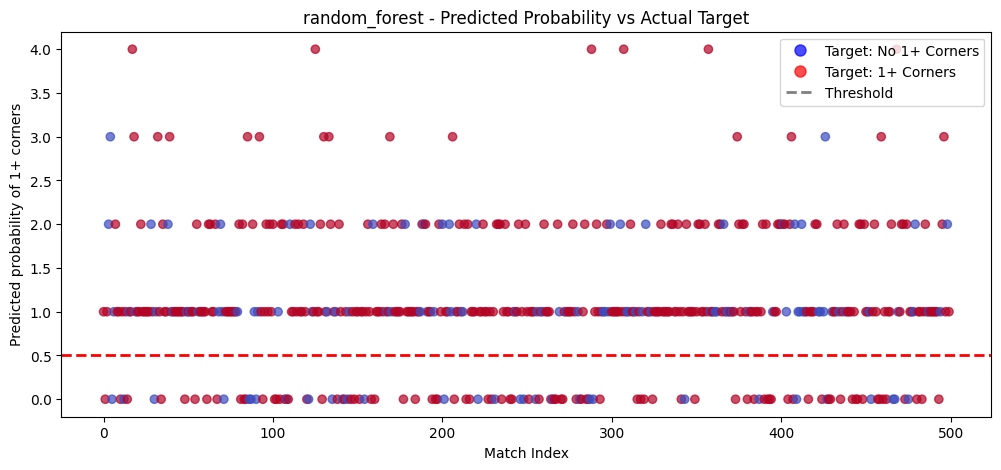


-> Running Backtest...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
8IJfW4hn/  1.28       100.00     -100.00    0          900.00    
6yO0SBfF/  1.28       90.00      -90.00     0          810.00    
URKjXpwt/  1.28       81.00      22.63      1          832.63    
zBEayApd/  1.29       83.26      23.97      1          856.60    
zF2xGqaj/  1.36       85.66      30.60      1          887.20    
buEcQM4b/  1.28       88.72      -88.72     0          798.48    
Cluu8ukU/  1.29       79.85      22.85      1          821.33    
dKLrKm2e/  1.27       82.13      21.97      1          843.30    
4pPjIRW7/  1.28       84.33      -84.33     0          758.97    
On1MHIla/  1.29       75.90      21.72      1          780.69    
riYnYwZu/  1.28       78.07      -78.07     0          702.62    
dIz4YCWE/  1.36       70.26      25.34      1          727.95    
pt2wtVOE/  1.28       72.80      20.59      1          748.54    
GrqYqOMo/  1.36       74.8

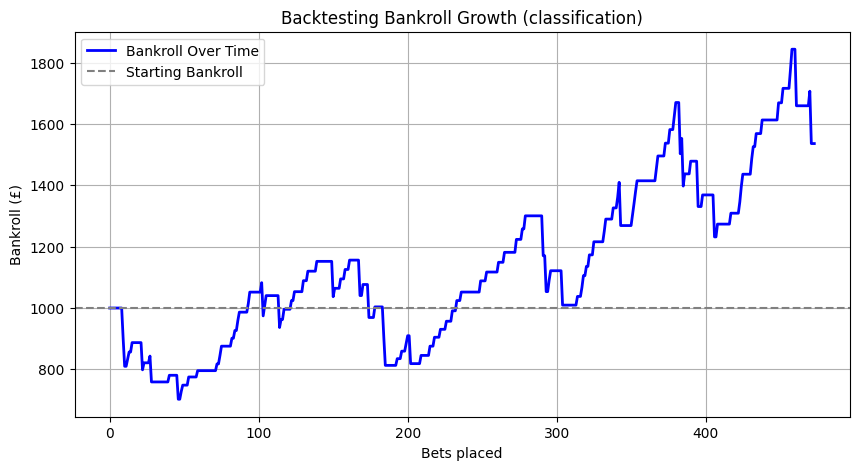

✅ Finished Running Regression Pipeline


In [38]:
run_regression_pipeline(config, df_selected, selected_features, constructed_features, target_variable=target_variable[0], show_output=True, generate_pdf=True)